In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
train_df = pd.read_excel(r'C:\Users\candr\Documents\masters\SecurityAnalysisDNN\src\SecurityAnalysisDNN\data\preparedData\12_05_2024\train_ordered_standardized_software.xlsx')
val_df = pd.read_excel(r'C:\Users\candr\Documents\masters\SecurityAnalysisDNN\src\SecurityAnalysisDNN\data\preparedData\12_05_2024\val_ordered_standardized_software.xlsx')

if 'index' in train_df.columns.to_list():
    train_df.drop(columns=['index'])
    val_df.drop(columns=['index'])

train_df.shape, val_df.shape

((938, 29), (246, 29))

In [3]:
for column in train_df.columns.to_list():
    train_df[column] = train_df[column].astype(float)
    val_df[column] = val_df[column].astype(float)

In [4]:
target_column = 'Close Price'
input_columns = train_df.columns.to_list()
input_columns.remove(target_column)

train_inputs = train_df[input_columns].values
train_targets = train_df[target_column].values

val_inputs = val_df[input_columns].values
val_targets = val_df[target_column].values

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

$$z = (x - u) / s$$

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

In [5]:
scaler = StandardScaler()
scaler.fit(train_inputs)

train_inputs = scaler.transform(train_inputs)
# train_targets = scaler.transform(train_targets)

val_inputs = scaler.transform(val_inputs)
# val_targets = scaler.transform(val_targets)

In [6]:
print(f"input_train_data.shape: {train_inputs.shape}, train_targets.shape: {train_targets.shape}")
print(f"input_val_data.shape: {val_inputs.shape}, val_targets.shape: {val_targets.shape}")

input_train_data.shape: (938, 28), train_targets.shape: (938,)
input_val_data.shape: (246, 28), val_targets.shape: (246,)


In [7]:
input_train_data_tensor = torch.tensor(train_inputs, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets.reshape((-1,1)), dtype=torch.float32)
input_val_data_tensor = torch.tensor(val_inputs, dtype=torch.float32)
val_targets_tensor = torch.tensor(val_targets.reshape((-1,1)), dtype=torch.float32)

# Creating datasets
train_dataset = TensorDataset(input_train_data_tensor, train_targets_tensor)
val_dataset = TensorDataset(input_val_data_tensor, val_targets_tensor)

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [8]:
class RegressionNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc4 = nn.Linear(hidden_size, 1)
        # self.relu4 = nn.ReLU()    # ! why, why not?

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu1(self.fc1(x))
        # x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        # x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        # x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [18]:
train_inputs.shape[1]

28

In [10]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
input_size = train_inputs.shape[1]
hidden_size = 50

# Model instantiation
model: nn.Module = RegressionNN(input_size, hidden_size).to(device)

# Loss and optimizer
criterion: nn.Module = nn.MSELoss()
optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [11]:
# A function to encapsulate the training loop
def batch_gd(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer,
             train_loader: DataLoader, test_loader: DataLoader, epochs: int):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # print("inputs.shape:", inputs.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss: torch.Tensor = criterion(outputs, targets)
                
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
        
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
        Test Loss: {test_loss:.4f}, Duration: {dt}')
    
    return train_losses, test_losses

In [12]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, val_loader, epochs=100)

Epoch 1/100, Train Loss: 3702.1643,         Test Loss: 30922.2863, Duration: 0:00:00.106057
Epoch 2/100, Train Loss: 3671.3836,         Test Loss: 30569.7928, Duration: 0:00:00.043564
Epoch 3/100, Train Loss: 3589.7138,         Test Loss: 29509.6040, Duration: 0:00:00.049906
Epoch 4/100, Train Loss: 3368.2727,         Test Loss: 26644.5347, Duration: 0:00:00.066640
Epoch 5/100, Train Loss: 2916.2507,         Test Loss: 21136.1693, Duration: 0:00:00.050057
Epoch 6/100, Train Loss: 2384.7529,         Test Loss: 15654.5018, Duration: 0:00:00.056468
Epoch 7/100, Train Loss: 1993.5280,         Test Loss: 13692.0934, Duration: 0:00:00.043599
Epoch 8/100, Train Loss: 1767.2897,         Test Loss: 13173.7688, Duration: 0:00:00.049836
Epoch 9/100, Train Loss: 1626.1444,         Test Loss: 12687.4891, Duration: 0:00:00.053074
Epoch 10/100, Train Loss: 1515.5802,         Test Loss: 12081.0292, Duration: 0:00:00.053328
Epoch 11/100, Train Loss: 1426.3849,         Test Loss: 11520.9384, Duration: 0

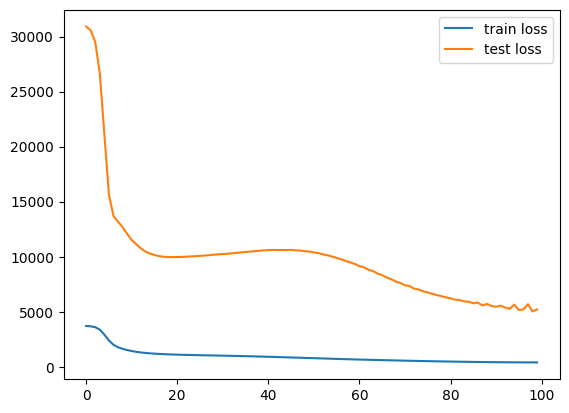

In [13]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [14]:
# Actual vs predicted for the test prices

def test_predictions(model, criterion, loader):
    predictions = []
    test_losses = []
    actual = []

    model.eval()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets: torch.Tensor
        p: torch.Tensor = model(inputs)
        loss = criterion(p, targets)
        test_losses.append(loss.item())

        predictions.extend(p.detach().numpy())
        actual.extend(targets.numpy())
    
    return predictions, actual, test_losses

In [15]:
preds, real, losses = test_predictions(model, criterion, val_loader)

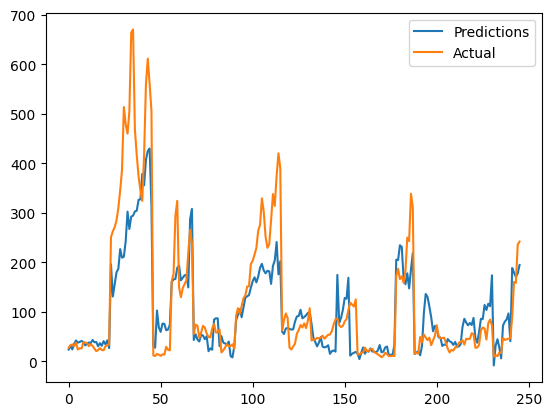

In [16]:
plt.plot(preds, label='Predictions')
plt.plot(real, label="Actual")
plt.legend()

In [17]:
# save the model
# look at the state dict
dateStr = datetime.date(datetime.now()).strftime("%d_%m_%Y")
# model.state_dict()
torch.save(model.state_dict(), f'RegressionNN_input_size_{input_size}_hidden_size_{hidden_size}_hidden_layers_3_epochs_100.pt')

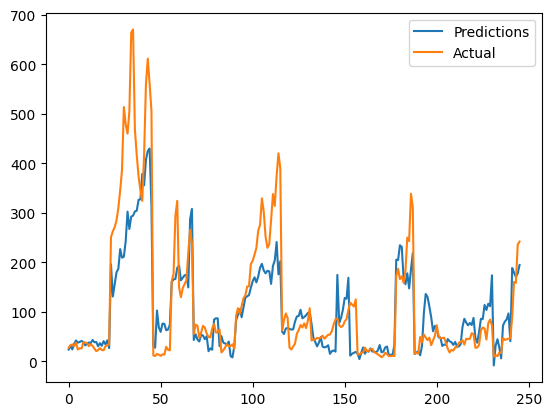

In [21]:
class RegressionNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)  # Adds dropout of 30%
        self.fc4 = nn.Linear(hidden_size, 1)
        # self.relu4 = nn.ReLU()    # ! why, why not?

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu1(self.fc1(x))
        # x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        # x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        # x = self.dropout3(x)
        x = self.fc4(x)
        return x

dnn_12_05_2024 = RegressionNN(input_size=28, hidden_size=50)
dnn_12_05_2024.load_state_dict(torch.load('RegressionNN_12_05_2024_input_size_28_hidden_size_50_hidden_layers_3_epochs_100.pt'))

preds, real, losses = test_predictions(model, criterion, val_loader)
plt.plot(preds, label='Predictions')
plt.plot(real, label="Actual")
plt.legend()